In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import UnitaryGate

In [2]:
matrix = ([[2**(-0.5),2**(-0.5)],[2**(-0.5),-2**(-0.5)]])
h_ideal = UnitaryGate(matrix)

In [3]:
def rot_surf_code(n: int) -> QuantumCircuit:              #1st anc = third last qubit = syndrome/parity measurement qubit, 2nd anc = sec last qubit = magic state for S Gate, 3rd anc = last qubit = magic state for T-Gate
    qr = QuantumRegister(9*n+3, "q")
    cbit = ClassicalRegister(4,"c")
    qc = QuantumCircuit(qr,cbit)
    list = []
    for i in range(0, 9*n):
        list.append("{:c}".format(i))
    list = qr
    for i in range(n):
        qc.h(list[9*i+1])
        qc.h(list[9*i+3])
        qc.h(list[9*i+5])
        qc.h(list[9*i+7])

        qc.cx(list[9*i+1],list[9*i])
        qc.cx(list[9*i+5],list[9*i+4])
        qc.cx(list[9*i+7],list[9*i+8])

        qc.cx(list[9*i+5],list[9*i+2])

        qc.cx(list[9*i+3],list[9*i+4])
        qc.cx(list[9*i+2],list[9*i+1])

        qc.cx(list[9*i+3],list[9*i+6])

        qc.cx(list[9*i+6],list[9*i+7])
    return qc

def X_L(circuit: QuantumCircuit, hadamard = False, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will X_L auf den ersten anwenden ---> n = 0 !!!
    if hadamard:
        circuit.x(9*n+3)
        circuit.x(9*n+4)
        circuit.x(9*n+5)
    else:
        circuit.x(9*n+1)
        circuit.x(9*n+4)
        circuit.x(9*n+7)
    return circuit

def Z_L(circuit: QuantumCircuit, hadamard = False, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will Z_L auf den ersten anwenden ---> n = 0 !!!
    if hadamard:
        circuit.z(9*n+1)
        circuit.z(9*n+4)
        circuit.z(9*n+7)
    else:
        circuit.z(9*n+3)
        circuit.z(9*n+4)
        circuit.z(9*n+5)
    return circuit

def Hadamard(circuit: QuantumCircuit, pos=0):              #H-Gates auf EINEN Circuit, wieder erster Circuit --> n = 0, zweiter Circuit --> n = 1 , usw.
    for i in range(9):
        circuit.h(9*pos+i)
    return circuit

def S_L(qc: QuantumCircuit, had = False, pos=0):
    ancilla = qc.num_qubits - 3
    magic_S = ancilla + 1
    qc.reset(magic_S)
    qc.reset(ancilla)

    #qc.h(magic_S)
    qc.append(h_ideal,[magic_S])
    qc.s(magic_S)

    qc.cx(magic_S,ancilla)
    qc = Z_parity(qc, hadamard=had, pos= pos)

    qc.measure(ancilla, 0)

    if had == False:
        with qc.if_test((0,1)):
            qc.z(3+9*pos)
            qc.z(4+9*pos)
            qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(1+9*pos)
            qc.z(4+9*pos)
            qc.z(7+9*pos)
    
    #qc.h(magic_S)
    qc.append(h_ideal,[magic_S])
    qc.measure(magic_S,0)
    
    if had == False:
        with qc.if_test((0,1)):
            qc.z(3+9*pos)
            qc.z(4+9*pos)
            qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(1+9*pos)
            qc.z(4+9*pos)
            qc.z(7+9*pos)
            
    return qc

def adjoint_S_L(qc: QuantumCircuit, had = False, pos=0):
    ancilla = qc.num_qubits - 3
    magic_S = ancilla + 1
    qc.reset(magic_S)
    qc.reset(ancilla)

    #qc.h(magic_S)
    qc.append(h_ideal,[magic_S])
    qc.sdg(magic_S)

    qc.cx(magic_S,ancilla)
    qc = Z_parity(qc, hadamard=had, pos= pos)

    qc.measure(ancilla, 0)

    if had == False:
        with qc.if_test((0,1)):
            qc.z(3+9*pos)
            qc.z(4+9*pos)
            qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(1+9*pos)
            qc.z(4+9*pos)
            qc.z(7+9*pos)
    
    #qc.h(magic_S)
    qc.append(h_ideal,[magic_S])
    qc.measure(magic_S,0)
    
    if had == False:
        with qc.if_test((0,1)):
            qc.z(3+9*pos)
            qc.z(4+9*pos)
            qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(1+9*pos)
            qc.z(4+9*pos)
            qc.z(7+9*pos)
            
    return qc

def Z_parity(circuit: QuantumCircuit, hadamard = False, pos = 0):
    qc = circuit
    ancilla = qc.num_qubits - 3
    if hadamard:
        qc.cx(1+9*pos,ancilla)
        qc.cx(4+9*pos,ancilla)
        qc.cx(7+9*pos,ancilla)
    else:
        qc.cx(3+9*pos,ancilla)
        qc.cx(4+9*pos,ancilla)
        qc.cx(5+9*pos,ancilla)
    return qc

def X_parity(circuit: QuantumCircuit, hadamard = False, pos = 0):
    qc = circuit
    ancilla = qc.num_qubits - 2
    #qc.h(ancilla)
    if hadamard:
        qc.cx(ancilla,3+9*pos)
        qc.cx(ancilla,4+9*pos)
        qc.cx(ancilla,5+9*pos)
    else:
        qc.cx(ancilla,1+9*pos)
        qc.cx(ancilla,4+9*pos)
        qc.cx(ancilla,7+9*pos)
    #qc.h(ancilla)
    return qc

def reset_logical_qubit(qc: QuantumCircuit, pos = 0):
    for i in range(9):
        qc.reset(9*pos+i)
    i = pos
    qc.h(9*i+1)
    qc.h(9*i+3)
    qc.h(9*i+5)
    qc.h(9*i+7)

    qc.cx(9*i+1, 9*i)
    qc.cx(9*i+5, 9*i+4)
    qc.cx(9*i+7, 9*i+8)

    qc.cx(9*i+5, 9*i+2)

    qc.cx(9*i+3, 9*i+4)
    qc.cx(9*i+2, 9*i+1)

    qc.cx(9*i+3,9*i+6)

    qc.cx(9*i+6,9*i+7)
    return qc
    
def T_L(circuit: QuantumCircuit, had = False, pos = 0):
    qc = circuit
    ancilla = qc.num_qubits - 3
    magic_S = ancilla + 1
    magic_T = ancilla + 2
    qc.reset(magic_T)
    qc.reset(ancilla)
    
    #qc.h(magic_T)
    qc.append(h_ideal,[magic_T])
    qc.t(magic_T)                 #Initliaisierung vom Magic State

    qc = Z_parity(qc, hadamard=had, pos = pos)

    qc.cx(magic_T, ancilla)

    qc.measure(ancilla,0)
    
    if had == False:
        with qc.if_test((0,1)):         #S_L von Dustin
            qc.reset(magic_S)
            qc.reset(ancilla)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.s(magic_S)

            qc.cx(magic_S,ancilla)
            qc.cx(3+9*pos,ancilla)
            qc.cx(4+9*pos,ancilla)
            qc.cx(5+9*pos,ancilla)
            
            qc.measure(ancilla,0)
            with qc.if_test((0,1)):
                qc.z(3+9*pos)
                qc.z(4+9*pos)
                qc.z(5+9*pos)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.measure(magic_S,0)
            with qc.if_test((0,1)):
                qc.z(3+9*pos)
                qc.z(4+9*pos)
                qc.z(5+9*pos)

    else:                               
        with qc.if_test((0,1)):
            qc.reset(magic_S)
            qc.reset(ancilla)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.s(magic_S)

            qc.cx(magic_S,ancilla)
            qc.cx(1+9*pos,ancilla)
            qc.cx(4+9*pos,ancilla)
            qc.cx(7+9*pos,ancilla)
            
            qc.measure(ancilla,0)
            with qc.if_test((0,1)):
                qc.z(1+9*pos)
                qc.z(4+9*pos)
                qc.z(7+9*pos)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.measure(magic_S,0)
            with qc.if_test((0,1)):
                qc.z(1+9*pos)
                qc.z(4+9*pos)
                qc.z(7+9*pos)
    
    #qc.h(magic_T)
    qc.append(h_ideal,[magic_T])
    qc.measure(magic_T,0)
    
    if had == False:
        with qc.if_test((0,1)):
            qc.z(3+9*pos)
            qc.z(4+9*pos)
            qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(1+9*pos)
            qc.z(4+9*pos)
            qc.z(7+9*pos)
    return qc

def adjoint_T_L(circuit: QuantumCircuit, had = False, pos = 0):
    qc = circuit
    ancilla = qc.num_qubits - 3
    magic_S = ancilla + 1
    magic_T = ancilla + 2
    qc.reset(magic_T)
    qc.reset(ancilla)
    
    #qc.h(magic_T)
    qc.append(h_ideal,[magic_T])
    qc.tdg(magic_T)                 #Initliaisierung vom Magic State

    qc = Z_parity(qc, hadamard=had, pos = pos)

    qc.cx(magic_T, ancilla)

    qc.measure(ancilla,0)
    
    if had == False:
        with qc.if_test((0,1)):         #S_L von Dustin
            qc.reset(magic_S)
            qc.reset(ancilla)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.sdg(magic_S)

            qc.cx(magic_S,ancilla)
            qc.cx(3+9*pos,ancilla)
            qc.cx(4+9*pos,ancilla)
            qc.cx(5+9*pos,ancilla)
            
            qc.measure(ancilla,0)
            with qc.if_test((0,1)):
                qc.z(3+9*pos)
                qc.z(4+9*pos)
                qc.z(5+9*pos)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.measure(magic_S,0)
            with qc.if_test((0,1)):
                qc.z(3+9*pos)
                qc.z(4+9*pos)
                qc.z(5+9*pos)

    else:                               
        with qc.if_test((0,1)):
            qc.reset(magic_S)
            qc.reset(ancilla)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.sdg(magic_S)

            qc.cx(magic_S,ancilla)
            qc.cx(1+9*pos,ancilla)
            qc.cx(4+9*pos,ancilla)
            qc.cx(7+9*pos,ancilla)
            
            qc.measure(ancilla,0)
            with qc.if_test((0,1)):
                qc.z(1+9*pos)
                qc.z(4+9*pos)
                qc.z(7+9*pos)
            #qc.h(magic_S)
            qc.append(h_ideal,[magic_S])
            qc.measure(magic_S,0)
            with qc.if_test((0,1)):
                qc.z(1+9*pos)
                qc.z(4+9*pos)
                qc.z(7+9*pos)
    
    #qc.h(magic_T)
    qc.append(h_ideal,[magic_T])
    qc.measure(magic_T,0)
    
    if had == False:
        with qc.if_test((0,1)):
            qc.z(3+9*pos)
            qc.z(4+9*pos)
            qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(1+9*pos)
            qc.z(4+9*pos)
            qc.z(7+9*pos)
    return qc

def CNOT(circuit:QuantumCircuit, hadamard = "00", control = 0):               #CNOT mit berücksichtigung der Rotation durch H-Gate
    if control == 0:
        if hadamard == "10":
            circuit.cx(control_qubit=0,target_qubit=9+6)
            circuit.cx(control_qubit=1,target_qubit=9+3)
            circuit.cx(control_qubit=2,target_qubit=9+0)
            circuit.cx(control_qubit=3,target_qubit=9+7)
            circuit.cx(control_qubit=4,target_qubit=9+4)
            circuit.cx(control_qubit=5,target_qubit=9+1)
            circuit.cx(control_qubit=6,target_qubit=9+8)
            circuit.cx(control_qubit=7,target_qubit=9+5)
            circuit.cx(control_qubit=8,target_qubit=9+2)
        elif hadamard == "01":
            circuit.cx(control_qubit=0,target_qubit=9+2)
            circuit.cx(control_qubit=1,target_qubit=9+5)
            circuit.cx(control_qubit=2,target_qubit=9+8)
            circuit.cx(control_qubit=3,target_qubit=9+1)
            circuit.cx(control_qubit=4,target_qubit=9+4)
            circuit.cx(control_qubit=5,target_qubit=9+7)
            circuit.cx(control_qubit=6,target_qubit=9+0)
            circuit.cx(control_qubit=7,target_qubit=9+3)
            circuit.cx(control_qubit=8,target_qubit=9+6)
        else:
            for i in range(9):
                circuit.cx(control_qubit=i,target_qubit=9+i)
    elif control == 1:
        if hadamard == "01":
            circuit.cx(control_qubit=9+0,target_qubit=6)
            circuit.cx(control_qubit=9+1,target_qubit=3)
            circuit.cx(control_qubit=9+2,target_qubit=0)
            circuit.cx(control_qubit=9+3,target_qubit=7)
            circuit.cx(control_qubit=9+4,target_qubit=4)
            circuit.cx(control_qubit=9+5,target_qubit=1)
            circuit.cx(control_qubit=9+6,target_qubit=8)
            circuit.cx(control_qubit=9+7,target_qubit=5)
            circuit.cx(control_qubit=9+8,target_qubit=2)
        elif hadamard == "10":
            circuit.cx(control_qubit=9+0,target_qubit=2)
            circuit.cx(control_qubit=9+1,target_qubit=5)
            circuit.cx(control_qubit=9+2,target_qubit=8)
            circuit.cx(control_qubit=9+3,target_qubit=1)
            circuit.cx(control_qubit=9+4,target_qubit=4)
            circuit.cx(control_qubit=9+5,target_qubit=7)
            circuit.cx(control_qubit=9+6,target_qubit=0)
            circuit.cx(control_qubit=9+7,target_qubit=3)
            circuit.cx(control_qubit=9+8,target_qubit=6)
        else: 
            for i in range(9):
                circuit.cx(control_qubit=9+i,target_qubit=i)
    return circuit

def control_S_L(circuit: QuantumCircuit, hadamard = "00", control = 0, target = 1):
    qc = circuit

    if control == 0:

        if hadamard == "01":
            qc = T_L(qc, had=False, pos=control)
            qc = T_L(qc, had=True, pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)
            qc = adjoint_T_L(qc,had=True,pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)
        elif hadamard == "10":
            qc = T_L(qc, had=True, pos=control)
            qc = T_L(qc, had=False, pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)
            qc = adjoint_T_L(qc,had=False,pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)
        else:   #hadamard = "00" = "11"
            qc = T_L(qc, had=False, pos=control)
            qc = T_L(qc, had=False, pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)
            qc = adjoint_T_L(qc,had=False,pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)

    elif control == 1:

        if hadamard == "01":
            qc = T_L(qc, had=True, pos=control)
            qc = T_L(qc, had=False, pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)
            qc = adjoint_T_L(qc,had=False,pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)
        elif hadamard == "10":
            qc = T_L(qc, had=False, pos=control)
            qc = T_L(qc, had=True, pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)
            qc = adjoint_T_L(qc,had=True,pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)
        else:   #hadamard = "00" = "11"
            qc = T_L(qc, had=False, pos=control)
            qc = T_L(qc, had=False, pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)
            qc = adjoint_T_L(qc,had=False,pos=target)
            qc = CNOT(qc, hadamard=hadamard,control=control)

    return qc

def control_Z_L(circuit: QuantumCircuit ,control = 0, target = 1):
    qc = circuit
    qc = Hadamard(qc, pos = target)
    qc = CNOT(qc, control = control)            #aufgrund des H eine Zeile drüber, geht das normale CNOT
    qc = Hadamard(qc, pos = target)
    return qc

def control_Z_L_test(circuit: QuantumCircuit, hadamard = "00", control = 0, target = 1):
    qc = circuit
    qc = S_L(qc, hadamard=False, pos=control)
    qc = S_L(qc, hadamard=True, pos=target)
    qc = CNOT(qc, hadamard=hadamard,control=control)
    qc = adjoint_S_L(qc,hadamard=True,pos=target)
    qc = CNOT(qc, hadamard=hadamard,control=control)
    return qc

def stabilize(circuit: QuantumCircuit, hadamard = False, pos = 0):                     #misst alle stabilizer, speichert den Fehler und korrigiert dementsprechend
    qc = circuit
    ancilla = qc.num_qubits - 3
    if hadamard:

        #X3 X6 Stabilizer:
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla,3+9*pos)
        qc.cx(ancilla,6+9*pos)
        qc.h(ancilla)
        qc.measure(ancilla,0)

        #X0 X1 X3 X4 Stabilizer:
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla,0+9*pos)
        qc.cx(ancilla,1+9*pos)
        qc.cx(ancilla,3+9*pos)
        qc.cx(ancilla,4+9*pos)
        qc.h(ancilla)
        qc.measure(ancilla,1)

        #X4 X5 X7 X8 Stabilizer:
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla,4+9*pos)
        qc.cx(ancilla,5+9*pos)
        qc.cx(ancilla,7+9*pos)
        qc.cx(ancilla,8+9*pos)
        qc.h(ancilla)
        qc.measure(ancilla,2)

        #X2 X5 Stabilizer:
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla,2+9*pos)
        qc.cx(ancilla,5+9*pos)
        qc.h(ancilla)
        qc.measure(ancilla,3)

        with qc.if_test((0,1)):             #6
            with qc.if_test((1,0)):
                qc.z(6+9*pos)

        with qc.if_test((0,1)):             #3
            with qc.if_test((1,1)):
                qc.z(3+9*pos)

        with qc.if_test((3,1)):             #2
            with qc.if_test((2,0)):
                qc.z(2+9*pos)
        
        with qc.if_test((3,1)):             #5
            with qc.if_test((2,1)):
                qc.z(5+9*pos)
        
        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.z(4+9*pos)

        with qc.if_test((0,0)):             #0 und 1
            with qc.if_test((1,1)):
                with qc.if_test((2,0)):
                    qc.z(0+9*pos)
        
        with qc.if_test((1,0)):             #7 und 8
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.z(7+9*pos)

    ###########################################################################################################

        #Z0 Z1 Stabilizer:
        qc.reset(ancilla)
        qc.cx(0+9*pos,ancilla)
        qc.cx(1+9*pos,ancilla)
        qc.measure(ancilla,0)

        #Z1 Z2 Z4 Z5 Stabilizer:
        qc.reset(ancilla)
        qc.cx(1+9*pos,ancilla)
        qc.cx(2+9*pos,ancilla)
        qc.cx(4+9*pos,ancilla)
        qc.cx(5+9*pos,ancilla)
        qc.measure(ancilla,1)
    
        #Z3 Z4 Z6 Z7 Stabilizer:
        qc.reset(ancilla)
        qc.cx(3+9*pos,ancilla)
        qc.cx(4+9*pos,ancilla)
        qc.cx(6+9*pos,ancilla)
        qc.cx(7+9*pos,ancilla)
        qc.measure(ancilla,2)

        #Z7 Z8 Stabilizer:
        qc.reset(ancilla)
        qc.cx(7+9*pos,ancilla)
        qc.cx(8+9*pos,ancilla)
        qc.measure(ancilla,3)
        
        with qc.if_test((0,1)):             #0
            with qc.if_test((1,0)):
                qc.x(0+9*pos)

        with qc.if_test((0,1)):             #1
            with qc.if_test((1,1)):
                qc.x(1+9*pos)
        
        with qc.if_test((3,1)):             #8
            with qc.if_test((2,0)):
                qc.x(8+9*pos)
        
        with qc.if_test((3,1)):             #7
            with qc.if_test((2,1)):
                qc.x(7+9*pos)
        
        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.x(4+9*pos)

        with qc.if_test((0,0)):             #2 und 5
            with qc.if_test((1,1)):
                with qc.if_test((2,0)):
                    qc.x(2+9*pos)
        
        with qc.if_test((1,0)):             #3 und 6
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.x(3+9*pos)

    else:
        #X0 X1 Stabilizer:
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla,0+9*pos)
        qc.cx(ancilla,1+9*pos)
        qc.h(ancilla)
        qc.measure(ancilla,0)
        
        #X1 X2 X4 X5 Stabilizer:
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla,1+9*pos)
        qc.cx(ancilla,2+9*pos)
        qc.cx(ancilla,4+9*pos)
        qc.cx(ancilla,5+9*pos)
        qc.h(ancilla)
        qc.measure(ancilla,1)

        #X3 X4 X6 X7 Stabilizer:
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla,3+9*pos)
        qc.cx(ancilla,4+9*pos)
        qc.cx(ancilla,6+9*pos)
        qc.cx(ancilla,7+9*pos)
        qc.h(ancilla)
        qc.measure(ancilla,2)

        #X7 X8 Stabilizer:
        qc.reset(ancilla)
        qc.h(ancilla)
        qc.cx(ancilla,7+9*pos)
        qc.cx(ancilla,8+9*pos)
        qc.h(ancilla)
        qc.measure(ancilla,3)

        with qc.if_test((0,1)):             #0
            with qc.if_test((1,0)):    
                qc.z(0+9*pos)
        
        with qc.if_test((0,1)):             #1
            with qc.if_test((1,1)):
                qc.z(1+9*pos)

        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.z(4+9*pos)

        with qc.if_test((2,1)):             #7
            with qc.if_test((3,1)):
                qc.z(7+9*pos)

        with qc.if_test((2,0)):             #8
            with qc.if_test((3,1)):
                qc.z(8+9*pos)

        with qc.if_test((0,0)):             #2 und 5
            with qc.if_test((1,1)):        
                with qc.if_test((2,0)):    
                    qc.z(2+9*pos)

        with qc.if_test((1,0)):             #3 und 6
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.z(3+9*pos)

    ###########################################################################################################

        #Z3 Z6 Stabilizer:
        qc.reset(ancilla)
        qc.cx(3+9*pos,ancilla)
        qc.cx(6+9*pos,ancilla)
        qc.measure(ancilla,0)

        #Z0 Z1 Z3 Z4 Stabilizer:
        qc.reset(ancilla)
        qc.cx(0+9*pos,ancilla)
        qc.cx(1+9*pos,ancilla)
        qc.cx(3+9*pos,ancilla)
        qc.cx(4+9*pos,ancilla)
        qc.measure(ancilla,1)
    
        #Z4 Z5 Z7 Z8 Stabilizer:
        qc.reset(ancilla)
        qc.cx(4+9*pos,ancilla)
        qc.cx(5+9*pos,ancilla)
        qc.cx(7+9*pos,ancilla)
        qc.cx(8+9*pos,ancilla)
        qc.measure(ancilla,2)

        #Z2 Z5 Stabilizer:
        qc.reset(ancilla)
        qc.cx(2+9*pos,ancilla)
        qc.cx(5+9*pos,ancilla)
        qc.measure(ancilla,3)
        
        with qc.if_test((0,1)):             #6
            with qc.if_test((1,0)):
                qc.x(6+9*pos)

        with qc.if_test((0,1)):             #3
            with qc.if_test((1,1)):
                qc.x(3+9*pos)

        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.x(4+9*pos)

        with qc.if_test((2,0)):             #2
            with qc.if_test((3,1)):
                qc.x(2+9*pos)

        with qc.if_test((2,1)):             #5
            with qc.if_test((3,1)):
                qc.x(5+9*pos)
        
        with qc.if_test((0,0)):             #0 und 1
            with qc.if_test((1,1)):
                with qc.if_test((2,0)):
                    qc.x(0+9*pos)
        
        with qc.if_test((1,0)):             #7 und 8
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.x(7+9*pos)
    return qc

def QEC(circuit: QuantumCircuit, hadamard = False, pos = 0, iterations = 1):
    for i in range(iterations):
        circuit = stabilize(circuit=circuit, hadamard=hadamard, pos=pos)
    return  circuit

def gates(circuit:QuantumCircuit):
    qc = circuit
    hmm = dict(qc.count_ops())
    return print("Amount of gates in this circuit: ", sum(hmm.values()))


In [8]:
qc = rot_surf_code(2)

qc = QEC(qc, False, 0, 1)

gates(qc)

Amount of gates in this circuit:  86


In [9]:
#Testcircuit für Control S_L (= 2nd iteration of iQPE)

qc = rot_surf_code(1)
ancilla = qc.num_qubits-3

qc = Hadamard(qc, 0)

for i in range(4):
    qc = T_L(qc, True, 0)

qc = Hadamard(qc, 0)

qc.reset(ancilla)

qc = Z_parity(qc, False,0)

qc.measure(ancilla,3)

gates(qc)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print("Wir wollen 1 _ _ _: ", counts)

Amount of gates in this circuit:  87
Wir wollen 1 _ _ _:  {'1000': 47, '1001': 52}


In [10]:
#Testcircuit für Control S_L (= 2nd iteration of iQPE)

qc = rot_surf_code(2)
ancilla = qc.num_qubits-3

qc = X_L(qc,False,1)
qc = Hadamard(qc, 0)

#qc = QEC(qc, True, pos = 0, iterations=1)

qc = control_S_L(qc, "10", control = 0, target = 1)

qc = QEC(qc, True, pos = 0, iterations=1)

qc = adjoint_S_L(qc, True, 0)

qc = Hadamard(qc, 0)

qc.reset(ancilla)

qc = Z_parity(qc, False,0)

qc.measure(ancilla,3)

gates(qc)

sim = AerSimulator()
job = sim.run(qc, shots=49)
result = job.result()
counts = result.get_counts()

print("Wir wollen 0 _ _ _: ", counts)

Amount of gates in this circuit:  182
Wir wollen 0 _ _ _:  {'0001': 32, '0000': 17}


{'111111111 1': 99}


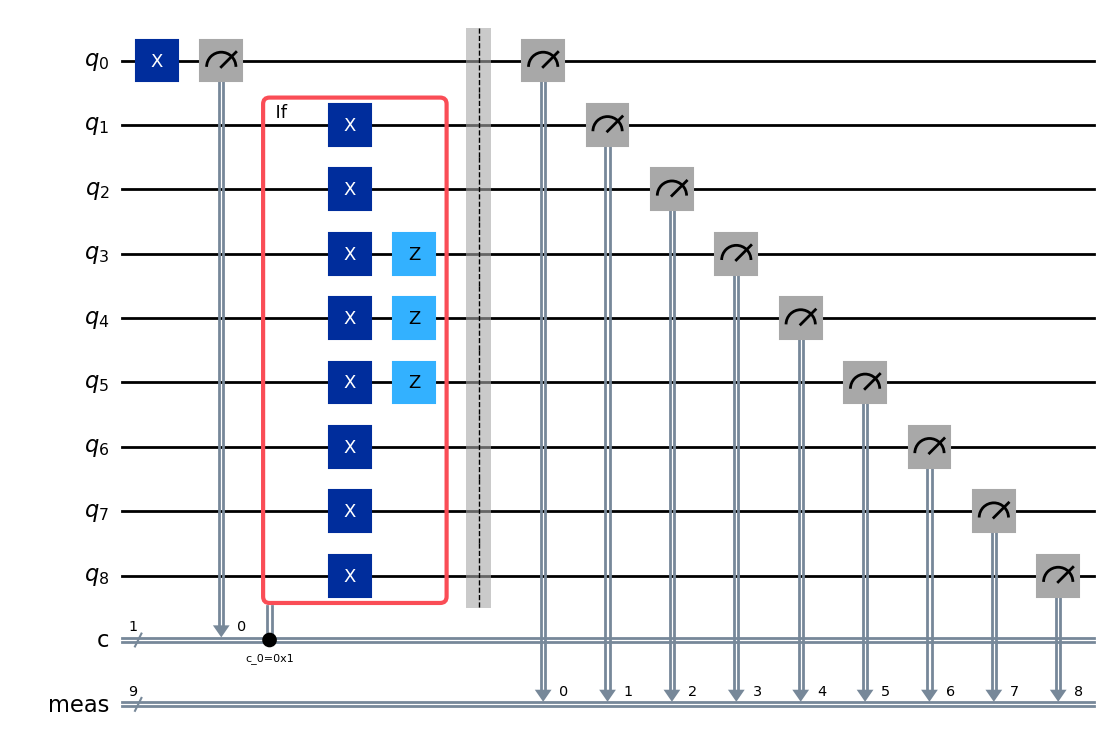

In [54]:
#"with qc.if_test()" funktioniert wie erwartet mit klassischen Qubits!

qr = QuantumRegister(9,"q")
cbit = ClassicalRegister(1,"c")

qc = QuantumCircuit(qr,cbit)

had = True

qc.x(0)
qc.measure(0,0)

pos = 0

if had:
    with qc.if_test((0,1)):
        qc.x(1+9*pos)
        qc.x(2+9*pos)
        qc.x(3+9*pos)
        qc.x(4+9*pos)
        qc.x(5+9*pos)
        qc.x(6+9*pos)
        qc.x(7+9*pos)
        qc.x(8+9*pos)

        qc.z(3+9*pos)
        qc.z(4+9*pos)
        qc.z(5+9*pos)
else:
    with qc.if_test((0,1)):
        qc.s(1+9*pos)
        qc.s(2+9*pos)
        qc.s(3+9*pos)
        qc.s(4+9*pos)
        qc.s(5+9*pos)
        qc.s(6+9*pos)
        qc.s(7+9*pos)
        qc.s(8+9*pos)

        qc.z(1+9*pos)
        qc.z(4+9*pos)
        qc.z(7+9*pos)

# with qc.if_test((0,1)) as else_:
#     qc.x(1)
# with else_:
#     qc.z(1)

qc.measure_all()

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print(counts)

qc.draw("mpl")

In [11]:
depolarizing_prob = 0.01
dep_error = depolarizing_error(depolarizing_prob, 1)
dep_error_2q = depolarizing_error(depolarizing_prob, 2)

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h'])  # Apply to single-qubit gates
noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

In [15]:
qc = rot_surf_code(1)

ancilla = qc.num_qubits - 2

pos = 0

qc = X_L(qc, False, 0)

#qc.x(4)

qc = stabilize(qc,False,0)

# qc.reset(ancilla)

# qc = X_L(qc, False, 0)

qc = Z_parity(qc, False, 0)

qc.measure(ancilla, 0)

shots = 99
sim = AerSimulator()
job = sim.run(qc, noise_model=noise_model, shots=shots)
result = job.result()
counts = result.get_counts()

print(counts)

{'1011': 2, '0100': 2, '0110': 4, '0010': 4, '0000': 87}


Wir erwarten 10_ _:  {'0000': 1, '1000': 34, '0001': 2, '1001': 47, '1101': 7, '1100': 8}
Amount of gates in this circuit:  216
Erfolgsrate:  0.8181818181818182


<BarContainer object of 2 artists>

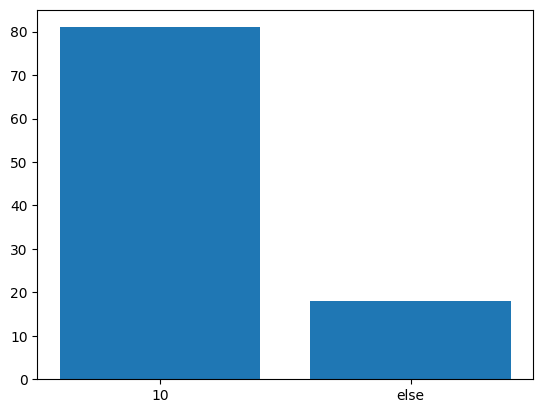

In [23]:
#Implementation von iQPE für 2 Iterationen mit Theta=90°

qc = rot_surf_code(2)

ancilla = qc.num_qubits - 2

qc = X_L(qc, n = 1)

#qc = QEC(qc, False, pos = 1, iterations = 3)

qc = Hadamard(qc, pos=0)

#qc = QEC(qc, True, pos = 0, iterations = 3)

qc = control_Z_L(qc)
qc = Hadamard(qc ,pos=0)

qc.reset(ancilla)

qc = Z_parity(qc,hadamard = False,pos=0)

qc.measure(ancilla,3)

qc = reset_logical_qubit(qc, pos = 0)
qc = reset_logical_qubit(qc, pos = 1)
qc.reset(ancilla)
qc.reset(ancilla+1)

qc = X_L(qc, n = 1)
qc = Hadamard(qc, 0)

qc = control_S_L(qc,"00")
qc = adjoint_S_L(qc, hadamard=True, pos = 0)
qc = Hadamard(qc, 0)

qc.reset(ancilla)
qc = Z_parity(qc, pos = 0)

qc.measure(ancilla,2)

sim = AerSimulator()
job = sim.run(qc, noise_model = noise_model, shots=99)
result = job.result()
counts = result.get_counts()
print("Wir erwarten 10_ _: ",counts)

gates(qc)
############################################################################################
x = list(counts.keys())
x = [i[0:2] for i in x]
y_old = list(counts.values())

success  =  0
for i in range(len(x)):
    if x[i] == "10":
        success += y_old[i]

print("Erfolgsrate: ", success/shots)
Erfolgsrate = success/shots

y = [0,0]

for i in range(len(x)):
    if x[i] == "10":
        y[0] += y_old[i]
    else:
        y[1] += y_old[i]

x = ["correct bitstring","else"]

plt.bar(x,y)

ValueError: x and y must have same first dimension, but have shapes (1,) and (20,)

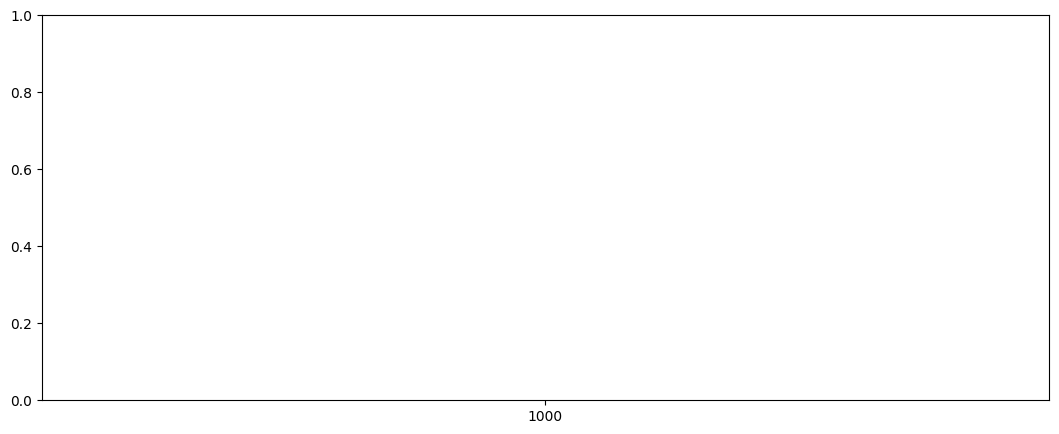

In [20]:
#Implementation von iQPE für 2 Iterationen mit Theta=90°
shots = 5000
x = np.linspace(0,0.050,20)
y = []
y_no_QEC = []
for i in x:
    success  =  0
    for p in range(shots):
        depolarizing_prob = i
        dep_error = depolarizing_error(depolarizing_prob, 1)
        dep_error_2q = depolarizing_error(depolarizing_prob, 2)
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h',"s","t","tdg","sdg"])  # Apply to single-qubit gates
        noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

        qc = rot_surf_code(2)
        ancilla = qc.num_qubits - 2
        qc = X_L(qc, n = 1)
        qc = Hadamard(qc, pos=0)
        qc = control_Z_L(qc)
        qc = Hadamard(qc ,pos=0)
        qc.reset(ancilla)
        qc = Z_parity(qc,hadamard = False,pos=0)
        qc = QEC(qc, False, pos = 0, iterations = 1)
        qc.measure(ancilla,3)

        sim = AerSimulator()
        job = sim.run(qc, noise_model = noise_model, shots=1)
        result = job.result()
        counts = result.get_counts()
        x = list(counts.keys())
        hmm_1 = x[0][0]

        qc = rot_surf_code(2)
        ancilla = qc.num_qubits - 2
        qc = X_L(qc, n = 1)
        qc = Hadamard(qc, 0)
        qc = control_S_L(qc,"00")
        if hmm_1 == "1":
            qc = adjoint_S_L(qc, hadamard=True, pos = 0)
        qc = Hadamard(qc, 0)
        qc.reset(ancilla)
        qc = Z_parity(qc, pos = 0)
        qc = QEC(qc, False, pos = 0, iterations = 1)
        qc.measure(ancilla,3)

        sim = AerSimulator()
        job = sim.run(qc, noise_model = noise_model, shots=1)
        result = job.result()
        counts = result.get_counts()

        x_old = list(counts.keys())
        hmm_2 = x_old[0][0]

        measurement = hmm_1 + hmm_2

        if measurement == "10":
            success += 1

    Erfolgsrate_err = success/shots

    y.append(Erfolgsrate_err)

    ######################################## Nochmal aber ohne QEC
    success  =  0
    for p in range(shots):
        depolarizing_prob = i
        dep_error = depolarizing_error(depolarizing_prob, 1)
        dep_error_2q = depolarizing_error(depolarizing_prob, 2)
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h',"s","t","tdg","sdg"])  # Apply to single-qubit gates
        noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

        qc = rot_surf_code(2)
        ancilla = qc.num_qubits - 2
        qc = X_L(qc, n = 1)
        qc = Hadamard(qc, pos=0)
        qc = control_Z_L(qc)
        qc = Hadamard(qc ,pos=0)
        qc.reset(ancilla)
        qc = Z_parity(qc,hadamard = False,pos=0)
        #qc = QEC(qc, False, pos = 0, iterations = 1)
        qc.measure(ancilla,3)

        sim = AerSimulator()
        job = sim.run(qc, noise_model = noise_model, shots=1)
        result = job.result()
        counts = result.get_counts()
        x = list(counts.keys())
        hmm_1 = x[0][0]

        qc = rot_surf_code(2)
        ancilla = qc.num_qubits - 2
        qc = X_L(qc, n = 1)
        qc = Hadamard(qc, 0)
        qc = control_S_L(qc,"00")
        if hmm_1 == "1":
            qc = adjoint_S_L(qc, hadamard=True, pos = 0)
        qc = Hadamard(qc, 0)
        qc.reset(ancilla)
        qc = Z_parity(qc, pos = 0)

        #qc = QEC(qc, False, pos = 0, iterations = 1)
        qc.measure(ancilla,3)

        sim = AerSimulator()
        job = sim.run(qc, noise_model = noise_model, shots=1)
        result = job.result()
        counts = result.get_counts()

        x_old = list(counts.keys())
        hmm_2 = x_old[0][0]

        measurement = hmm_1 + hmm_2

        if measurement == "10":
            success += 1

    Erfolgsrate = success/shots
    y_no_QEC.append(Erfolgsrate)

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red")
ax.plot(x,y_no_QEC, label = "Without QEC", color="blue")
plt.title("Successrate of iQPE on a rotated surface Code with and w.o. QEC before Measurement of the Circuit")
plt.xlabel("Depolarizing error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
data = np.array((x,y,y_no_QEC))
np.savetxt("iQPE_whole_circuit_5000_shots.txt", data, delimiter=",")
plt.show()

In [38]:
depolarizing_prob = 0.01
dep_error = depolarizing_error(depolarizing_prob, 1)
dep_error_2q = depolarizing_error(depolarizing_prob, 2)

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h'])  # Apply to single-qubit gates
noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

Erfolgsrate:  0.6269
Wir erwarten 1 _ _ _:  {'1111': 287, '0001': 361, '1010': 1039, '1100': 1066, '0101': 276, '1001': 428, '1110': 797, '1000': 1780, '0110': 655, '1101': 424, '0100': 611, '0000': 561, '0010': 545, '0111': 389, '0011': 333, '1011': 448}


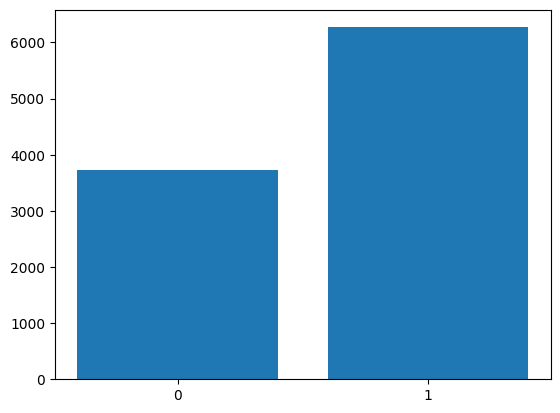

In [53]:
#Implementation von iQPE für 2 Iterationen mit Theta=90°  : Erste Iteration

qc = rot_surf_code(2)

ancilla = qc.num_qubits - 3

qc = X_L(qc, False, n = 1)

#qc.x(5)

#qc = QEC(qc, pos = 0, hadamard=False, iterations = 1)

#qc = QEC(qc, pos = 1, hadamard=False, iterations = 1)

qc = Hadamard(qc, pos=0)

#qc = QEC(qc, pos = 0, hadamard=True, iterations = 1)

# qc = control_S_L(qc,"00")
# qc = control_S_L(qc,"00")
qc = control_Z_L(qc,control=0,target=1)

#qc = QEC(qc, True, pos = 0, iterations = 1)

qc = Hadamard(qc ,pos=0)

qc = QEC(qc, pos= 0, hadamard=False, iterations = 1)

qc.reset(ancilla)

qc = Z_parity(qc,hadamard = False,pos=0)

qc.measure(ancilla,3)

shots = 10000
sim = AerSimulator()
job = sim.run(qc, noise_model=noise_model,shots=shots)
result = job.result()
counts = result.get_counts()

x = list(counts.keys())
x = [i[0] for i in x]
y_old = list(counts.values())

success  =  0
for i in range(len(x)):
    if x[i] == "1":
        success += y_old[i]

print("Erfolgsrate: ", success/shots)

y = [0,0]

for i in range(len(x)):
    if x[i] == "0":
        y[0] += y_old[i]
    elif x[i] == "1":
        y[1] += y_old[i]

x = ["0","1"]

plt.bar(x,y)

print("Wir erwarten 1 _ _ _: ",counts)

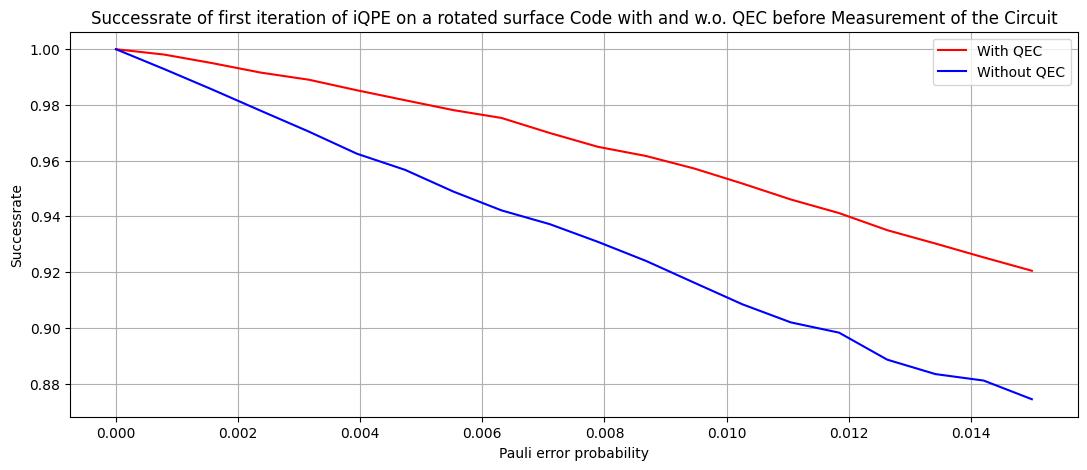

In [153]:
x = np.linspace(0,0.015,20)
y = []
y_no_QEC = []
shots = 50000
for i in x:
    # depolarizing_prob = i
    # dep_error = depolarizing_error(depolarizing_prob, 1)
    # dep_error_2q = depolarizing_error(depolarizing_prob, 2)
    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h'])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

    p = i
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XX",p/6],["XI",p/6],["IX",p/6],["II",1-p],["ZZ",p/6],["ZI",p/6],["IZ",p/6]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h'])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates
    
    qc = rot_surf_code(2)
    ancilla = qc.num_qubits - 3

    qc = X_L(qc, False, n = 1)
    qc = Hadamard(qc, pos=0)
    qc = control_Z_L(qc,control=0,target=1)
    qc = Hadamard(qc ,pos=0)

    qc = QEC(qc, pos= 0, hadamard=False, iterations = 1)

    qc.reset(ancilla)

    qc = Z_parity(qc,hadamard = False,pos=0)

    qc.measure(ancilla,3)

    sim = AerSimulator()
    job = sim.run(qc, noise_model = noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    x_old = list(counts.keys())
    x_old = [j[0] for j in x_old]
    y_old = list(counts.values())

    success  =  0
    for j in range(len(x_old)):
        if x_old[j] == "1":
            success += y_old[j]
    Erfolgsrate = success/shots
    y.append(Erfolgsrate)
    ######################################## Nochmal aber ohne QEC
    qc = rot_surf_code(2)
    ancilla = qc.num_qubits - 3

    qc = X_L(qc, False, n = 1)
    qc = Hadamard(qc, pos=0)
    qc = control_Z_L(qc,control=0,target=1)
    qc = Hadamard(qc ,pos=0)
    qc.reset(ancilla)
    qc = Z_parity(qc,hadamard = False,pos=0)
    qc.measure(ancilla,3)

    sim = AerSimulator()
    job = sim.run(qc, noise_model = noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    x_old = list(counts.keys())
    x_old = [j[0] for j in x_old]
    y_old = list(counts.values())

    success  =  0
    for j in range(len(x_old)):
        if x_old[j] == "1":
            success += y_old[j]

    Erfolgsrate = success/shots
    y_no_QEC.append(Erfolgsrate)

data = np.array((x,y,y_no_QEC))
#np.savetxt("QEC_50k_shots_Pauli_XZ_compare.txt", data, delimiter=",")

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red")
ax.plot(x,y_no_QEC, label = "Without QEC", color="blue")
plt.title("Successrate of first iteration of iQPE on a rotated surface Code with and w.o. QEC before Measurement of the Circuit")
plt.xlabel("Pauli error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
plt.show()

In [134]:
#Gatezahl für zweite Iteration

qc = rot_surf_code(2)
ancilla = qc.num_qubits - 3

qc = X_L(qc, False, n = 1)
qc = Hadamard(qc, pos=0)
qc = control_Z_L(qc,control=0,target=1)
qc = Hadamard(qc ,pos=0)

#qc.reset(ancilla)
qc = Z_parity(qc, pos = 0)

#qc.measure(ancilla,3)

gates(qc)

Amount of gates in this circuit:  75


In [143]:
#Gatezahl für QEC

print("Amount of gates in this circuit:  32")

Amount of gates in this circuit:  32


Wir erwarten 0 _ _ _:  {'0000': 51, '0001': 48}
Erfolgsrate:  1.0


<BarContainer object of 2 artists>

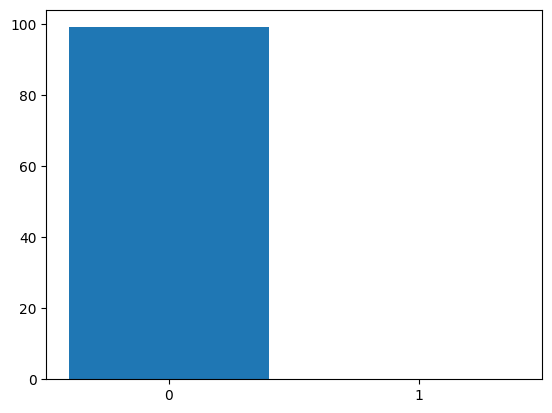

In [13]:
#Implementation von iQPE für 2 Iterationen mit Theta=90°  : Zweite Iteration

depolarizing_prob = 0.01
dep_error = depolarizing_error(depolarizing_prob, 1)
dep_error_2q = depolarizing_error(depolarizing_prob, 2)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h',"s","sdg"])  # Apply to single-qubit gates
noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

qc = rot_surf_code(2)

ancilla = qc.num_qubits - 2

qc = X_L(qc, n = 1)
qc = Hadamard(qc, 0)

qc = control_S_L(qc,"00",control = 0, target = 1)
qc = adjoint_S_L(qc, hadamard=True, pos = 0)
qc = Hadamard(qc, 0)

#qc = QEC(qc, hadamard=False, pos=0, iterations=1)

qc.reset(ancilla)
qc = Z_parity(qc, pos = 0)

qc.measure(ancilla,3)

shots = 99

sim = AerSimulator()
job = sim.run(qc, shots=shots)
result = job.result()
counts = result.get_counts()
print("Wir erwarten 0 _ _ _: ",counts)

x = list(counts.keys())
x = [i[0] for i in x]
y_old = list(counts.values())

success  =  0
for i in range(len(x)):
    if x[i] == "0":
        success += y_old[i]

print("Erfolgsrate: ", success/shots)

y = [0,0]

for i in range(len(x)):
    if x[i] == "0":
        y[0] += y_old[i]
    elif x[i] == "1":
        y[1] += y_old[i]

x = ["0","1"]

plt.bar(x,y)

In [135]:
#Gatezahl für zweite Iteration

qc = rot_surf_code(2)
ancilla = qc.num_qubits - 3
qc = X_L(qc, n = 1)
qc = Hadamard(qc, 0)
qc = control_S_L(qc,"10",control = 0, target = 1)
qc = adjoint_S_L(qc, had=True, pos = 0)
qc = Hadamard(qc, 0)

#qc.reset(ancilla)
qc = Z_parity(qc, pos = 0)

#qc.measure(ancilla,3)


gates(qc)

Amount of gates in this circuit:  118


Amount of gates in this circuit:  120


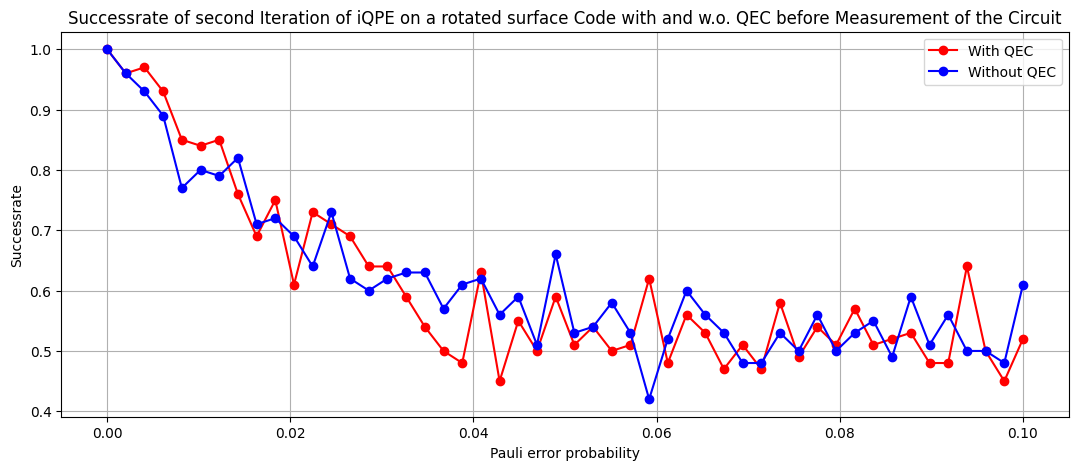

In [ ]:
shots = 7500
x = np.linspace(0,0.05,50)
y = []
y_no_QEC = []
for i in x:
    # depolarizing_prob = i
    # dep_error = depolarizing_error(depolarizing_prob, 1)
    # dep_error_2q = depolarizing_error(depolarizing_prob, 2)         #"s","t","tdg","sdg"
    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(dep_error, ['x',"z",'h'])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

    p = i
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XX",p/6],["XI",p/6],["IX",p/6],["II",1-p],["ZZ",p/6],["ZI",p/6],["IZ",p/6]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h'])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

    
    qc = rot_surf_code(2)
    ancilla = qc.num_qubits - 3
    qc = X_L(qc, n = 1)
    qc = Hadamard(qc, 0)

    #qc = control_S_L(qc,"10",control = 0, target = 1)

    qc = T_L(qc, had=True, pos=0)
    qc = T_L(qc, had=False, pos=1)

    qc = QEC(qc, True, pos = 0, iterations=1)
    qc = QEC(qc, False, pos = 1, iterations=1)

    qc = CNOT(qc, hadamard="10",control=0)
    qc = adjoint_T_L(qc,had=False,pos=1)
    qc = CNOT(qc, hadamard="10",control=0)
    qc = adjoint_S_L(qc, had=True, pos = 0)
    qc = Hadamard(qc, 0)

    qc = QEC(qc, False, pos = 0, iterations=1)

    qc.reset(ancilla)
    qc = Z_parity(qc, pos = 0)

    qc.measure(ancilla,3)

    sim = AerSimulator()
    job = sim.run(qc, noise_model=noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    x_old = list(counts.keys())
    x_old = [j[0] for j in x_old]
    y_old = list(counts.values())

    success  =  0
    for j in range(len(x_old)):
        if x_old[j] == "0":
            success += y_old[j]
            
    Erfolgsrate = success/shots
    y.append(Erfolgsrate)
    ######################################## Nochmal aber ohne QEC
    qc = rot_surf_code(2)
    ancilla = qc.num_qubits - 3
    qc = X_L(qc, n = 1)
    qc = Hadamard(qc, 0)
    qc = control_S_L(qc,"10",control = 0, target = 1)
    qc = adjoint_S_L(qc, had=True, pos = 0)
    qc = Hadamard(qc, 0)
    qc.reset(ancilla)
    qc = Z_parity(qc, pos = 0)

    qc.measure(ancilla,3)
    
    sim = AerSimulator()
    job = sim.run(qc, noise_model = noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    x_old = list(counts.keys())
    x_old = [j[0] for j in x_old]
    y_old = list(counts.values())

    success  =  0
    for j in range(len(x_old)):
        if x_old[j] == "0":
            success += y_old[j]

    Erfolgsrate = success/shots
    y_no_QEC.append(Erfolgsrate)

data = np.array((x,y,y_no_QEC))
np.savetxt("iQPE_2nd_step_7500_shots_ideal_magic_states_pauli_xz_new_5.txt", data, delimiter=",")

gates(qc)

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red", marker = "o")
ax.plot(x,y_no_QEC, label = "Without QEC", color="blue", marker = "o")
plt.title("Successrate of second Iteration of iQPE on a rotated surface Code with and w.o. QEC before Measurement of the Circuit")
plt.xlabel("Pauli error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
plt.show()

In [74]:
qc = rot_surf_code(2)
ancilla = qc.num_qubits - 3

qc = adjoint_T_L(qc,had=False,pos=1)
qc = CNOT(qc, hadamard="10",control=0)

qc = adjoint_S_L(qc, had=True, pos = 0)
qc = Hadamard(qc, 0)



gates(qc)

Amount of gates in this circuit:  68


In [14]:
#Implementation von iQPE für 2 Iterationen mit Theta=270°

qc = rot_surf_code(2)

ancilla = qc.num_qubits - 2

qc = X_L(qc, n = 1)
qc = Hadamard(qc, pos=0)
qc = control_Z_L(qc)
qc = Hadamard(qc ,pos=0)

qc.reset(ancilla)

qc = Z_parity(qc,hadamard = False,pos=0)

qc.measure(ancilla,3)


qc = reset_logical_qubit(qc, pos = 0)
qc = reset_logical_qubit(qc, pos = 1)
qc.reset(ancilla)
qc.reset(ancilla+1)

qc = X_L(qc, n = 1)
qc = Hadamard(qc, 0)

qc = control_Z_L(qc)
qc = control_S_L(qc,"00")
qc = adjoint_S_L(qc, hadamard=True, pos = 0)
qc = Hadamard(qc, 0)

qc.reset(ancilla)
qc = Z_parity(qc, pos = 0)

qc.measure(ancilla,2)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()
print("Wir erwarten 11 _ _: ",counts)

Wir erwarten 11 _ _:  {'1100': 52, '1101': 47}


In [28]:
qc = rot_surf_code(1)                           #Logisches S scheint zu funktionieren!

ancilla = qc.num_qubits - 2

qc = Hadamard(qc, 0)

qc = S_L(qc, hadamard=True, pos=0)

qc = S_L(qc, hadamard=True, pos=0)

#qc = Z_L(qc, False, 0)

qc = Hadamard(qc, 0)
# qc = X_L(qc,1)

qc = Z_parity(qc, False, 0)

qc.measure(ancilla,3)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print("Wir wollen 1 _ _ _:", counts)

Wir wollen 1 _ _ _: {'1000': 99}


Wir erwarten 1000, aber das bekommen wir:  {'1000': 99}


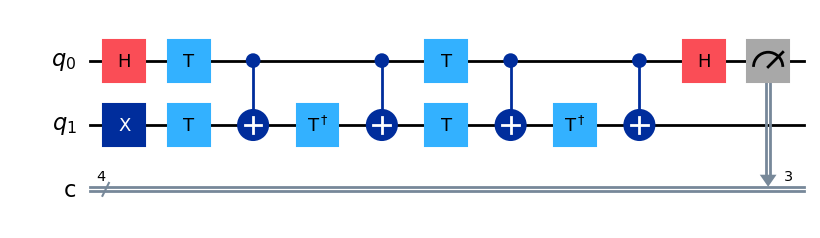

In [68]:
qr = QuantumRegister(2,"q")                     #Klassische Version vom Controlled S funktioniert!!!
cbit = ClassicalRegister(4,"c")
qc = QuantumCircuit(qr,cbit)

qc.x(1)

qc.h(0)

for i in range(2):
    qc.t(0)
    qc.t(1)
    qc.cx(0,1)
    qc.tdg(1)
    qc.cx(0,1)

qc.h(0)

qc.measure(0,3)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()
print("Wir erwarten 1000, aber das bekommen wir: ",counts)

qc.draw("mpl")

Wir erwarten 10, aber das bekommen wir:  {'10': 99}


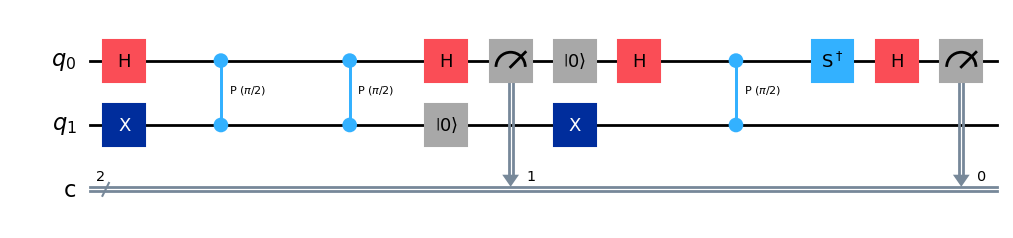

In [69]:
qr = QuantumRegister(2,"q")                     #Klassische Version von iQPE funktioniert!!!
cbit = ClassicalRegister(2,"c")
qc = QuantumCircuit(qr,cbit)

qc.x(1)

qc.h(0)

qc.cp(np.pi/2,0,1)
qc.cp(np.pi/2,0,1)

qc.h(0)

qc.measure(0,1)

qc.reset(0)
qc.reset(1)

qc.x(1)
qc.h(0)
qc.cp(np.pi/2,0,1)
qc.sdg(0)
qc.h(0)
qc.measure(0,0)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()
print("Wir erwarten 10, aber das bekommen wir: ",counts)

qc.draw("mpl")

{'11': 99}


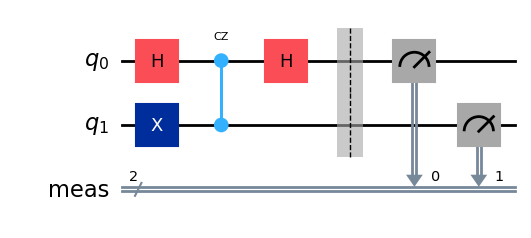

In [70]:
qr = QuantumRegister(2,"q")                     #Klassischer Circuit vom Code drunter zur Veranschaulichung!
cbit = ClassicalRegister(4,"c")
qc = QuantumCircuit(qr)

qc.x(1)

qc.h(0)

qc.cz(0,1,"CZ")

qc.h(0)

qc.measure_all()

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print(counts)

qc.draw("mpl")

Wir wollen 1:  {'1': 99}


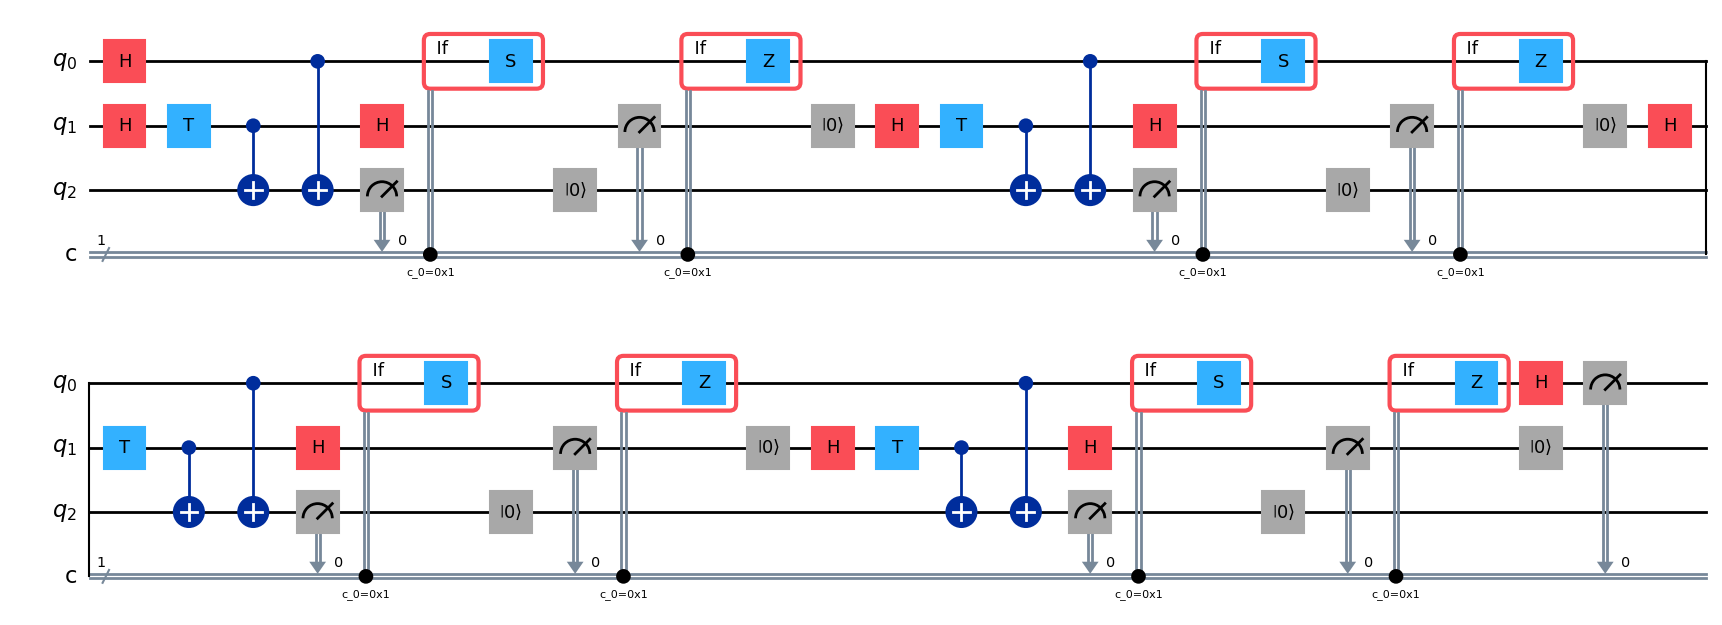

In [32]:
qr = QuantumRegister(3,"q")             #Klassisches Version von der T-Gate Initialisierung funktioniert!!!
cbit = ClassicalRegister(1,"c")

qc = QuantumCircuit(qr,cbit)

qc.h(0)

for i in range(4):                         #4-mal T-Gate auf |+> ---> |->
    qc.h(1)
    qc.t(1)

    qc.cx(1,2)
    qc.cx(0,2)

    qc.measure(2,0)

    with qc.if_test((0,1)):
        qc.s(0)

    qc.h(1)

    qc.measure(1,0)

    with qc.if_test((0,1)):
        qc.z(0)
    qc.reset(1)
    qc.reset(2)

qc.h(0)             # |-> ---> |1>

qc.measure(0,0)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print("Wir wollen 1: ", counts)

qc.draw("mpl")

In [50]:
qc = rot_surf_code(2)               #Logische Version vom Controlled S funktioniert net gescheid :/

ancilla = qc.num_qubits - 2

qc = Hadamard(qc,0)

qc = X_L(qc, False, n = 1)

# qc = control_S_L(qc, hadamard="10", control = 1, target = 0)

# qc = control_S_L(qc, hadamard="10", control = 1, target = 0)
qc = control_Z_L(qc, control=1 , target=0)

qc = Hadamard(qc,0)

qc = Z_parity(qc, False, 0)                             #Der zweite logische Qubit wird richtig gemessen (Ohne Hadamards)
qc.measure(ancilla,3)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print("Wir wollen 1 _ _ _: ", counts)

Wir wollen 1 _ _ _:  {'1000': 99}


In [108]:
qc = rot_surf_code(2)                   #CNOT und parity Measurements sind H sensibel, Z_L/X_L nicht!

ancilla  = qc.num_qubits - 2

magic = ancilla + 1

qc = Hadamard(qc,0)

qc = CNOT(qc, "01", control = 0)

qc = CNOT(qc, "01", control = 1)

qc = X_L(qc,True,0)

#qc.cx(magic,ancilla)

qc = Z_parity(qc,True,0)

qc.measure(ancilla,3)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print("Wir wollen 1 _ _ _: ", counts)

Wir wollen 1 _ _ _:  {'1000': 99}


In [73]:
qc = rot_surf_code(2)                  

ancilla  = qc.num_qubits - 2

magic = ancilla + 1

qc = Hadamard(qc,1)

qc = X_L(qc,0)

qc = CNOT(qc, "01", control = 0)

#qc = Hadamard(qc,0)

qc.h(ancilla)
qc = X_parity(qc,True,1)
qc.h(ancilla)

qc.measure(ancilla,3)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print("Wir wollen 1 _ _ _: ", counts)

Wir wollen 1 _ _ _:  {'0000': 99}


In [74]:
qc = rot_surf_code(2)                  

ancilla  = qc.num_qubits - 2

magic = ancilla + 1

qc = Hadamard(qc,1)

qc = X_L(qc,0)

qc = CNOT(qc, "01", control = 1)
qc = Z_L(qc,True,0)
qc = CNOT(qc, "01", control = 1)

qc = Hadamard(qc,1)

qc = Z_parity(qc,False,1)

qc.measure(ancilla,3)

sim = AerSimulator()
job = sim.run(qc, shots=99)
result = job.result()
counts = result.get_counts()

print("Wir wollen 1 _ _ _: ", counts)

Wir wollen 1 _ _ _:  {'1000': 99}
